In [1]:
import h5py
import xarray as xr
import numpy as np
import xgcm
import xrft
from xgcm import Grid

from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from bbl_utils import *

import warnings
warnings.filterwarnings('ignore', '.*FutureWarning*.')
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

In [2]:
nIter = 10
step0 = 7200
nstep = step0*2

iters = range(step0,nIter*nstep+step0,nstep)
iters_mean = range(nstep, nIter*nstep, nstep)
print(list(iters))

[7200, 21600, 36000, 50400, 64800, 79200, 93600, 108000, 122400, 136800]


In [7]:
#data_dir = "../../MITgcm/experiments/rotated_hyperdiffusion/run/"
#data_dir = "../../MITgcm/experiments/rotated_gaussian_noise/run/"
data_dir = "../../MITgcm/experiments/rotated_hyperdiffusion_no-rigid-lid/run/"
ds =  open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["snapDiag"])
#ds =  open_mdsdataset(data_dir,iters=iters_mean,ignore_unknown_vars=True,prefix=["Diag", "standardDiag"])
ds, coords, grid = pre_process(ds)

Γ = 0.0008613659531090722
θ = 2.e-3

ds, coords = add_cartesian_coordinates(ds, coords, θ)
ds = add_background_temp(ds, Γ)

In [8]:
T = ds['THETA'].where(ds['THETA'] != 0.)

In [9]:
ζ = (-grid.diff(ds.UVEL * coords.dxC, 'Y', boundary='extend')
     +grid.diff(ds.VVEL * coords.dyC, 'X', boundary='extend'))/coords.rAz
ζ

<xarray.DataArray (time: 10, Z: 300, YG: 128, XG: 128)>
dask.array<truediv, shape=(10, 300, 128, 128), dtype=float64, chunksize=(1, 300, 127, 127), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 4.32e+05 1.296e+06 2.16e+06 ... 7.344e+06 8.208e+06
  * Z        (Z) float64 3.108e+03 3.041e+03 2.977e+03 ... 6.0 2.0 -2.0
  * YG       (YG) >f8 0.0 300.0 600.0 900.0 ... 3.75e+04 3.78e+04 3.81e+04
  * XG       (XG) >f8 0.0 300.0 600.0 900.0 ... 3.75e+04 3.78e+04 3.81e+04

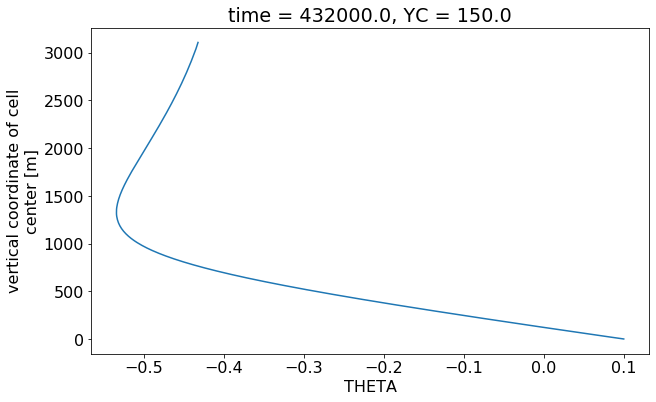

In [13]:
T.isel(YC=0, time=0).mean(dim=['XC']).plot(y = 'Z')

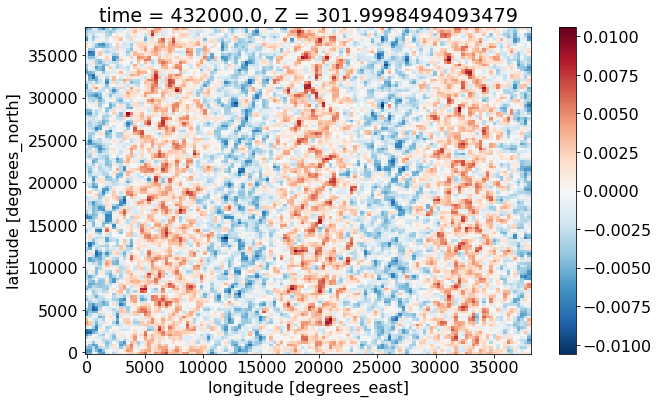

In [16]:
f = 0.53e-4
(ζ/f).sel(Z=300, method='nearest').isel(time=0).plot()

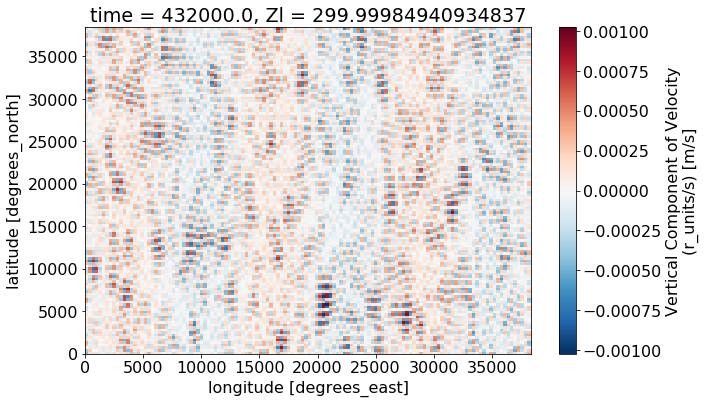

In [22]:
ds['WVEL'].sel(Zl=300, method='nearest').isel(time=0).plot()

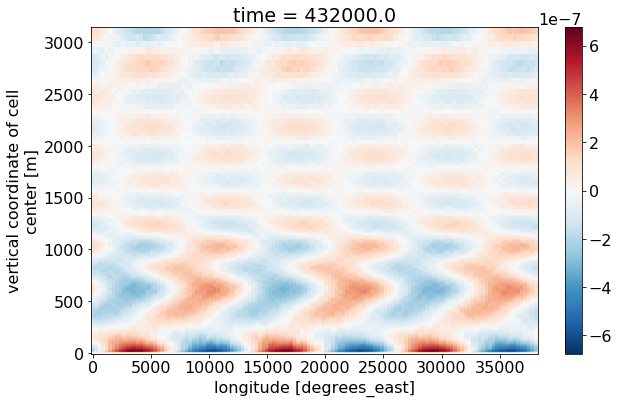

In [17]:
(ζ.isel(time=0)).mean(dim='YG').plot()

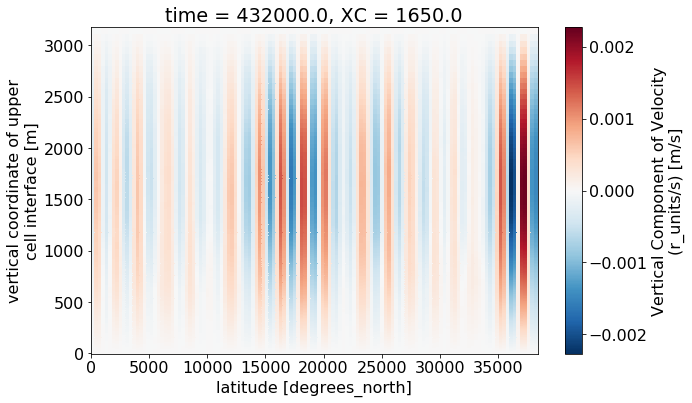

In [18]:
ds['WVEL'].isel(time=0).isel(XC=5).plot()

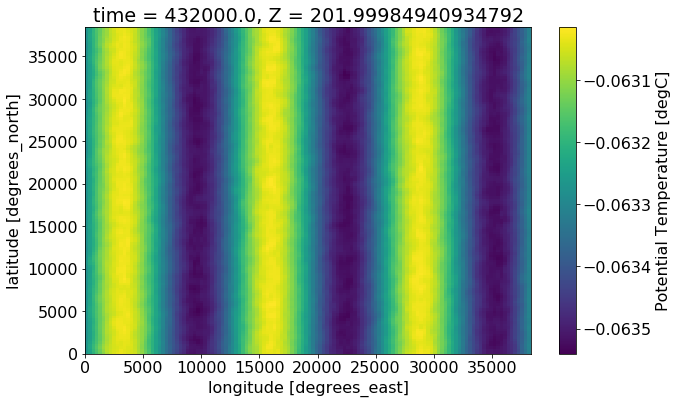

In [20]:
(ds['THETA']).sel(Z=200, method='nearest').isel(time=0).plot()

### Spectral analysis

In [9]:
u = ds['UVEL'].sel(Z=300, method='nearest')
v = ds['VVEL'].sel(Z=300, method='nearest')

uhat2 = xrft.power_spectrum(grid.interp(u,'X').chunk({'time':1, 'YC':128, 'XC':128}),
                         dim=['XC','YC'], detrend='linear', window=True).compute()
vhat2 = xrft.power_spectrum(grid.interp(v,'Y').chunk({'time':1, 'YC':128, 'XC':128}),
                         dim=['XC','YC'], detrend='linear', window=True).compute()

ekehat = .5*(uhat2 + vhat2)
ekehat;

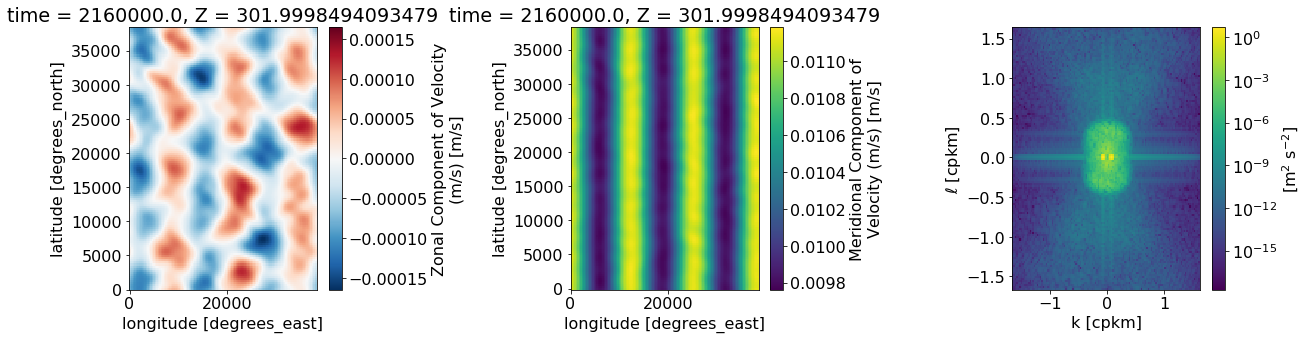

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
fig.set_tight_layout(True)
u.isel(time=-1).plot(ax=axes[0])
v.isel(time=-1).plot(ax=axes[1])
im = axes[2].pcolormesh(ekehat.freq_XC*1e3, ekehat.freq_YC*1e3, ekehat.isel(time=-1),
                       norm=colors.LogNorm())
cbar = fig.colorbar(im, ax=axes[2])
cbar.set_label(r'[m$^2$ s$^{-2}$]')
axes[2].set_xlabel(r'k [cpkm]')
axes[2].set_ylabel(r'$\ell$ [cpkm]');

### Rotated plots

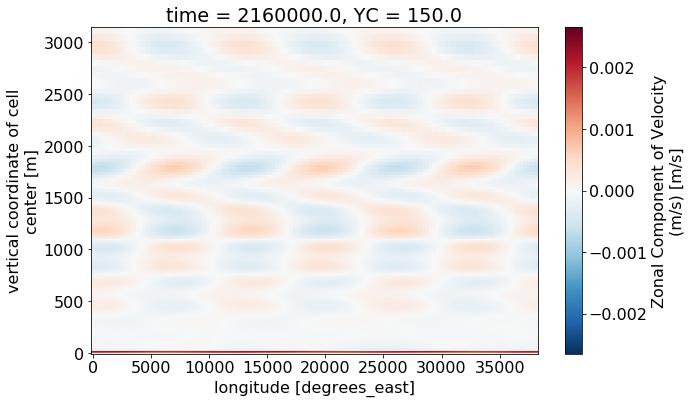

In [37]:
ds['UVEL'].isel(time=-1, YC=0).plot()

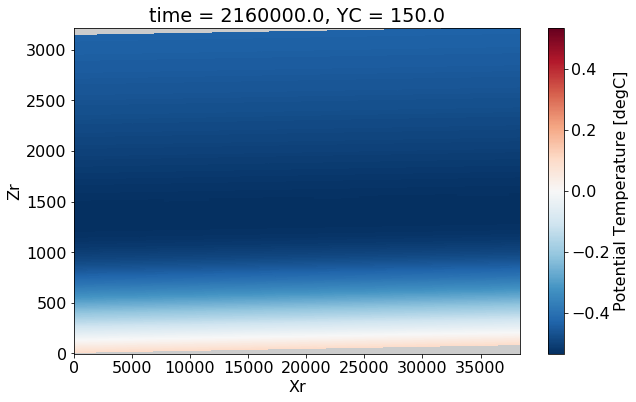

In [38]:
plt.subplot(1,1,1, facecolor=(.8, .8, .8))
ds['THETA'].isel(time=-1, YC=0).plot(x='Xr', y='Zr')

(0, 500)

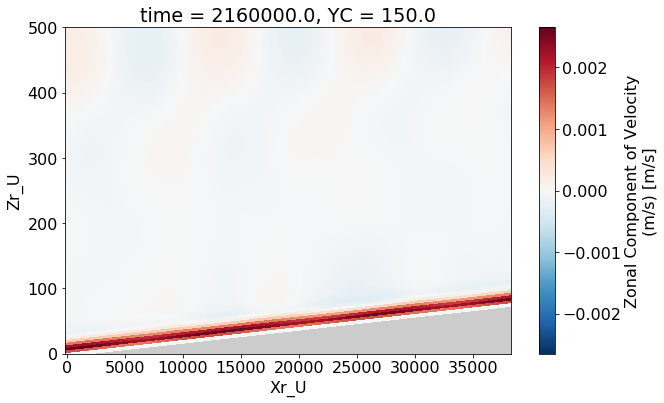

In [39]:
plt.subplot(1,1,1, facecolor=(.8, .8, .8))
ds['UVEL'].isel(time=-1, YC=0).plot(x='Xr_U', y='Zr_U')
plt.ylim([0, 500])

In [325]:
ds['THETA'].plot(x=)

<xarray.DataArray 'THETA' (time: 3, Z: 300, YC: 128, XC: 128)>
dask.array<concatenate, shape=(3, 300, 128, 128), dtype=float64, chunksize=(1, 300, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float64 -33.6 -99.9 -164.4 ... -3.135e+03 -3.139e+03 -3.143e+03
  * time     (time) float64 4.32e+05 1.296e+06 2.16e+06
  * XC       (XC) >f8 150.0 450.0 750.0 ... 3.765e+04 3.795e+04 3.825e+04
  * YC       (YC) >f8 150.0 450.0 750.0 ... 3.765e+04 3.795e+04 3.825e+04
Attributes:
    standard_name:  THETA
    long_name:      Potential Temperature
    units:          degC

In [140]:
plt.pcolormesh(ds['Xr'].values.swapaxes(0,1), ds['Zr'].values, ds['UVEL'].isel(YC=64, time=-1)*1e3, cmap='RdBu_r')


In [165]:
ds['Xr'].values.swapaxes(0,1)

array([[  150.06690012,   450.06630012,   750.06570013, ...,
        37649.99190015, 37949.99130015, 38249.99070015],
       [  150.19950183,   450.19890183,   750.19830183, ...,
        37650.12450186, 37950.12390186, 38250.12330186],
       [  150.32855459,   450.32795459,   750.32735459, ...,
        37650.25355461, 37950.25295461, 38250.25235461],
       ...,
       [  156.27047212,   456.26987212,   756.26927212, ...,
        37656.19547215, 37956.19487215, 38256.19427215],
       [  156.27847212,   456.27787212,   756.27727212, ...,
        37656.20347214, 37956.20287214, 38256.20227214],
       [  156.28647211,   456.28587211,   756.28527211, ...,
        37656.21147213, 37956.21087213, 38256.21027214]])

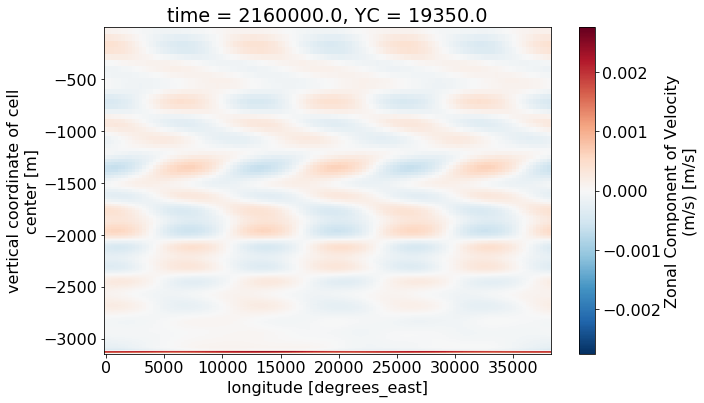

In [260]:
ds['UVEL'].isel(YC=64, time=-1).plot()

(0.9961946980917455, 0.08715574274765817, -0.08715574274765817, 0.9961946980917455, 0.0, 0.0)


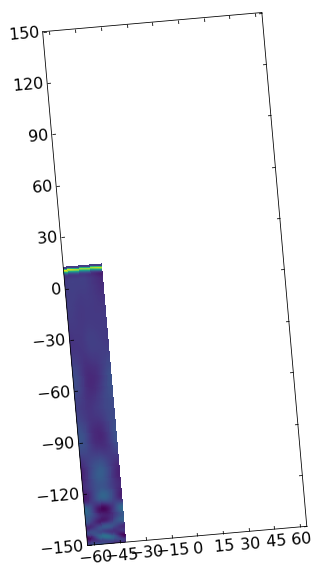

In [244]:
fig = plt.figure(figsize=(10,10))

plot_extents = -64, 64., -150, 150.
transform = Affine2D().rotate_deg(5)
#transform = Affine2D().rotate_deg_around(64, 150, 5)

print(transform.to_values())

helper = floating_axes.GridHelperCurveLinear(transform, plot_extents)
ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)

fig.add_subplot(ax)
ax.pcolormesh(ds['UVEL'].isel(YC=64, time=-1)*1e3, transform=transform)
#ax.pcolormesh(ds['Xr'].values.swapaxes(0,1), ds['Zr'].values, ds['UVEL'].isel(YC=64, time=-1)*1e3)

#ax.pcolormesh(ds['Xr'].values.swapaxes(0,1), ds['Zr'].values, ds['UVEL'].isel(YC=64, time=-1)*1e3)
plt.show()

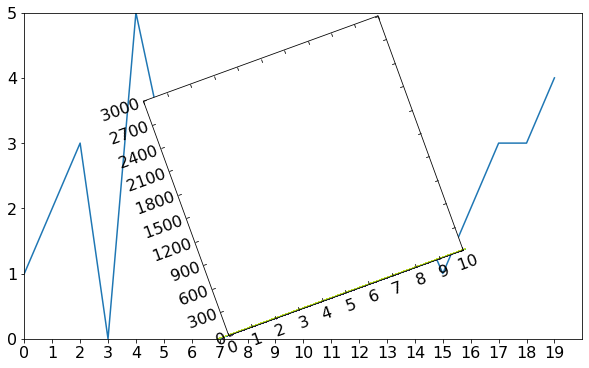

In [304]:
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import numpy as np
fig,ax = plt.subplots()
y=[1,2,3,0,5,3,2,1,2,3,2,1,2,3,2,1,2,3,3,4]
x=np.arange(len(y))
plt.plot(x,y)
ax.set_xlim((0,np.max(x)+1))
ax.set_ylim((0,np.max(y)))
ax.set_xticks(x)

plot_extents = 0, 10, 0, 3000
transform = Affine2D().scale(300,1).rotate_deg(20)
helper = floating_axes.GridHelperCurveLinear(transform, plot_extents)
ax1 = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)

fig.add_subplot(ax1)
transform = Affine2D().scale(300,1).rotate_deg(20).translate(tx=0.3, ty=0.6)
aux_ax = ax1.get_aux_axes(transform)
aux_ax.pcolormesh(np.arange(3000).reshape([10,300]))

plt.show()

([<matplotlib.axis.XTick at 0x7fe308421dc0>,
 <a list of 2 Text xticklabel objects>)

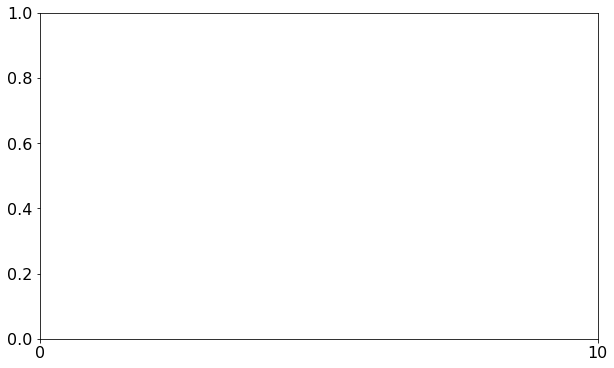

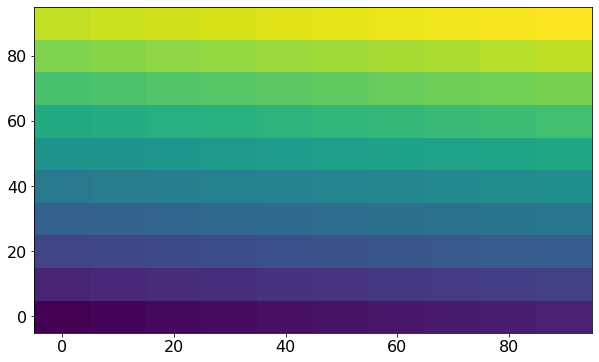

In [254]:
plt.pcolormesh(np.arange(-5,100,10.), np.arange(-5,100,10.), np.arange(100).reshape([10,10]))

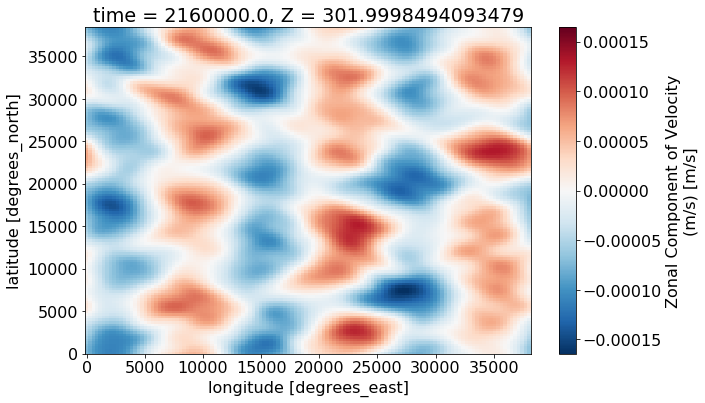

In [138]:
u.isel(time=-1).plot()

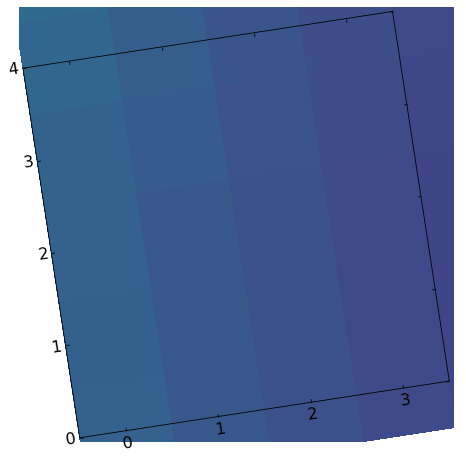

In [130]:
fig = plt.figure(figsize=(8, 8))
ax1, aux_ax1 = setup_axes(fig, 131)
#aux_ax1.bar([0, 1, 2, 3], [3, 2, 1, 3])
aux_ax1.pcolor(u.isel(time=-1))
#u.isel(time=-1).plot(ax=aux_ax1)
plt.show()

<matplotlib.axes._subplots.Floating AxesHostAxesSubplot at 0x7ff73901e520>

In [90]:
ylim = [0, 500]
xlim = [0, 3.84e4]

NameError: name 't' is not defined

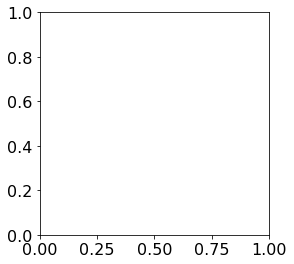

In [108]:
slice_time = nIter*180.*60.

ylim = [0., 300.]
tlim = [0, slice_time]

plt.figure(figsize=(14,9))

plt.subplot(2,3,1)
plt.pcolormesh(t, z, b*1.e4, cmap=div_cmap)
plt.colorbar(label='buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.clim([-2.,2.])
plt.xlabel('time [days]')
plt.xticks([0,25*86400., 50*86400.], [0, 25, 50])

plt.subplot(2,3,2)
g = 9.81; tAlpha = 2.e-4
ds['b'] = ds['THETA']*(g*tAlpha)
q = (ds['b'].mean(dim=['XC','YC'])*1.e4).plot(y='Z')
q.set_clim([-2.,2.])
q.colorbar.set_label('buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.xlabel('time [days]')
plt.xticks([0,25*86400., 50*86400.], [0, 25, 50])

plt.subplot(2,3,3)
ds_hills['b'] = ds_hills['THETA']*(g*tAlpha)

plt.plot(
    ds['b'].isel(time=np.argmin(np.abs(ds['time']-slice_time))).mean(dim=['XC','YC']).values*1.e4,
    ds['Z'],
    label='MITgcm')

plt.plot(b[:,[np.argmin(np.abs(t-slice_time))]]*1.e4, z, "--", label='dedalus')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim([-2.,2.])
plt.xlabel(r'buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.legend()

plt.subplot(2,3,4)
plt.pcolormesh(t, z, v*100., cmap=div_cmap)
plt.colorbar(label='along-slope velocity [cm/s]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.clim([-1.,1.])
plt.xlabel('time [days]')
plt.xticks([0,25*86400., 50*86400.], [0, 25, 50])

plt.subplot(2,3,5)
q = (ds['VVEL'].mean(dim=['XC','YG'])*100.).plot(y='Z')
q.set_clim([-1.,1.])
q.colorbar.set_label('along-slope velocity [cm/s]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.xlabel('time [days]')
plt.xticks([0,25*86400., 50*86400.], [0, 25, 50])


plt.subplot(2,3,6)
plt.plot(
    ds['VVEL'].isel(time=np.argmin(np.abs(ds['time']-slice_time))).mean(dim=['XC','YG']).values*100.,
    ds['Z'],
    label='MITgcm')

plt.plot(v[:,[np.argmin(np.abs(t-slice_time))]]*100., z, "--", label='dedalus')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim([-1.,1.])
plt.xlabel('along-slope velocity [cm/s]')

plt.tight_layout()
plt.savefig("../../figures/bbl_compare_dedalus.png", dpi=100, bbox_inches='tight')

In [150]:
θ = 2.e-3
Γ = 0.0008613

ds['Zr'] = ds['Z']*np.cos(θ) + ds['XC']*np.sin(θ)
ds['Xr'] = ds['XC']*np.cos(θ) - ds['Z']*np.sin(θ)

ds['THETA'] = ds['THETA'].where(ds['THETA'].isel(time=0) != 0.)
ds['THETA_BG'] = ds['THETA'] + ds['Zr'] * Γ


ds_hills['Zr'] = ds_hills['Z']*np.cos(θ) + ds_hills['XC']*np.sin(θ)
ds_hills['Xr'] = ds_hills['XC']*np.cos(θ) - ds_hills['Z']*np.sin(θ)

ds_hills['THETA'] = ds_hills['THETA'].where(ds_hills['THETA'].isel(time=0) != 0.)
ds_hills['THETA_BG'] = ds_hills['THETA'] + ds_hills['Zr'] * Γ

NameError: name 'ds_hills' is not defined

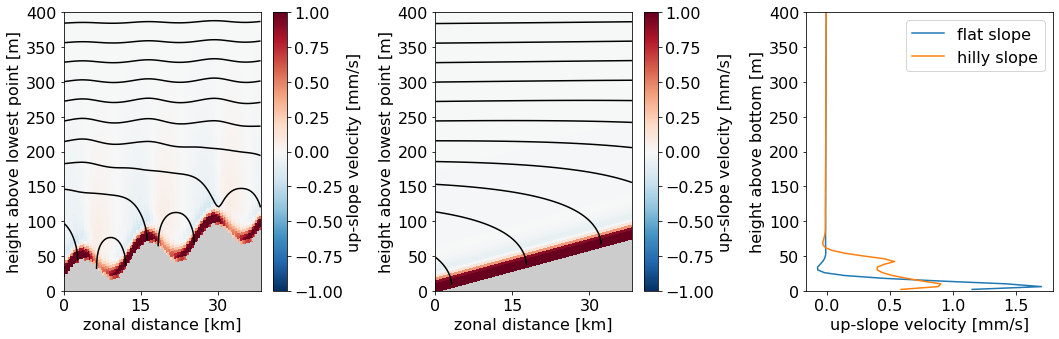

In [9]:
ulim = [-1., 1.]

ds['UVEL'] = ds['UVEL'].where(ds['UVEL'].isel(time=0) != 0.)
ds_hills['UVEL'] = ds_hills['UVEL'].where(ds_hills['UVEL'].isel(time=0) != 0.)

plt.figure(figsize=(15, 5))
ax = plt.subplot(1,3,1, facecolor=(.8, .8, .8))
plt.pcolormesh(ds_hills['Xr'].values.swapaxes(0,1), ds_hills['Zr'].values, ds_hills['UVEL'].isel(YC=64, time=-1)*1e3, cmap='RdBu_r')
plt.clim(ulim)
plt.colorbar(label='up-slope velocity [mm/s]')
plt.contour(ds_hills['Xr'].values.swapaxes(0,1), ds_hills['Zr'].values, ds_hills['THETA_BG'].isel(YC=64, time=-1), colors='k', levels=np.arange(0.,2., 0.025))
plt.ylim([0,400])
plt.ylabel('height above lowest point [m]')
plt.xticks([0,1.5e4,3.0e4], [0, 15, 30])
plt.xlabel('zonal distance [km]')

plt.subplot(1,3,2, facecolor=(.8, .8, .8))
plt.pcolormesh(ds['Xr'].values.swapaxes(0,1), ds_hills['Zr'].values, ds['UVEL'].isel(YC=64, time=-1)*1e3, cmap='RdBu_r')
plt.clim(ulim)
plt.colorbar(label='up-slope velocity [mm/s]')
plt.contour(ds_hills['Xr'].values.swapaxes(0,1), ds_hills['Zr'].values, ds['THETA_BG'].isel(YC=64, time=-1), colors='k', levels=np.arange(0.,2., 0.025))
plt.ylim([0,400])
plt.ylabel('height above lowest point [m]')
plt.xticks([0,1.5e4,3.0e4], [0, 15, 30])
plt.xlabel('zonal distance [km]')

plt.subplot(1,3,3)
plt.plot(
    ds['UVEL'].isel(time=-1).mean(dim=['XG','YC'], skipna=True).values*1e3,
    ds['Z'],
    label='flat slope')

plt.plot(
    ds_hills['UVEL'].isel(time=-1).mean(dim=['XG','YC'], skipna=True).values*1e3,
    ds_hills['Z'],
    label='hilly slope')
plt.ylim([0,400])
plt.ylabel('height above bottom [m]')
plt.legend()
plt.xlabel('up-slope velocity [mm/s]')

plt.tight_layout()

plt.savefig("../../figures/bbl_hills_spinup.png", dpi=100, bbox_inches='tight')

# See floating axes demo

https://stackoverflow.com/questions/52191695/rotate-transformation-on-matplotlib-axis-in-subplot

https://matplotlib.org/gallery/axisartist/demo_floating_axes.html

https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html